### Dinámica Secular del sistema

# Descripción

Este notebook carga los archivos de salida generados por `ncorp13` (por ejemplo `ncorp13.dat`, `planet1.dat`, `planet2.dat`, ...) y grafica la evolución temporal de los elementos orbitales: a, e, inc, M, w, O y la longitud del pericentro ϖ = w + O.

Cada elemento se grafica en su propia celda para facilitar la ejecución y la exportación de figuras.

In [1]:
# Celda: utilidades para cargar datos, calcular ϖ y hacer análisis espectral
import numpy as np
import scipy.signal as ss
from scipy import fftpack
from numpy import pi
import subprocess
import os

def load_ncorp(filename, cols=None, skiprows=0):
    """Leer archivo NCORP simple con columnas en blanco.
    cols: dict nombre->col_index (0-based) si se conoce."""
    data = np.loadtxt(filename, comments='#', skiprows=skiprows)
    return data

def compute_varpi(w_deg, O_deg):
    """Devuelve ϖ en rad, unwrap para continuidad temporal."""
    w = np.deg2rad(w_deg)
    O = np.deg2rad(O_deg)
    varpi = O + w
    varpi = np.unwrap(varpi)
    return varpi

def is_uniform(t, rtol=1e-3):
    dt = np.diff(t)
    return np.allclose(dt, dt.mean(), rtol=rtol)

def spectral_fft(x, dt):
    # devuelve freqs (Hz) y amplitudes
    n = len(x)
    X = fftpack.rfft(x - np.mean(x))
    freqs = fftpack.rfftfreq(n, d=dt)
    amp = np.abs(X)/n
    return freqs, amp


def spectral_lombscargle(t, x, fmin=None, fmax=None, nout=10000, max_mem=2e8, resample_uniform=True, max_uniform_N=200000):
    """
    Lomb-Scargle seguro frente a memoria.
    - reduce nout si la estimación de memoria es demasiado grande
    - si aún es grande y resample_uniform=True interpola a rejilla uniforme y usa FFT
    Retorna: freqs (1/time_unit), amp (amplitud)
    """
    t0 = np.asarray(t) - t[0]
    x = np.asarray(x)
    n = len(t0)
    if n < 3:
        return np.array([]), np.array([])

    if fmin is None:
        fmin = 1e-6
    if fmax is None:
        fmax = 1.0 / (2.0 * np.median(np.diff(t0)))

    # estimación de memoria (bytes) para construir ang = freqs * t -> n * nout * 8
    est_bytes = n * int(nout) * 8
    if est_bytes > max_mem:
        # reducir nout para ajustarse a max_mem (con mínimo razonable)
        nout_allowed = max(int(max_mem / (n * 8)), 256)
        nout = min(int(nout), nout_allowed)

    # recalcular estimación y, si sigue siendo grande, hacer remuestreo uniforme + FFT
    est_bytes = n * int(nout) * 8
    if est_bytes > max_mem and resample_uniform:
        N = min(max_uniform_N, max(256, n))
        t_uniform = np.linspace(t0[0], t0[-1], N)
        x_uniform = np.interp(t_uniform, t0, x)
        dt = t_uniform[1] - t_uniform[0]
        freqs, amp = spectral_fft(x_uniform, dt)
        return freqs, amp

    freqs = np.linspace(fmin, fmax, int(nout))
    ang = 2.0 * np.pi * freqs
    # scipy.signal.lombscargle puede fallar si hay NaN/inf
    mask = np.isfinite(t0) & np.isfinite(x)
    if not np.all(mask):
        t0 = t0[mask]; x = x[mask]
        if len(t0) < 3:
            return np.array([]), np.array([])

    p = ss.lombscargle(t0, x - np.mean(x), ang, precenter=False, normalize=False)
    amp = np.sqrt(4.0 * p / len(t0))
    return freqs, amp

def find_peaks_freq(freqs, amp, height=None, distance=None, topk=6):
    peaks, props = ss.find_peaks(amp, height=height, distance=distance)
    if len(peaks)==0:
        idx = np.argsort(amp)[-topk:][::-1]
        return freqs[idx], amp[idx]
    idx = np.argsort(amp[peaks])[-topk:][::-1]
    return freqs[peaks][idx], amp[peaks][idx]

def estimate_varpi_circulation_period(t, varpi_rad):
    # ajuste lineal para obtener tasa media de precesión (rad / same time unit as t)
    p = np.polyfit(t, varpi_rad, 1)
    omega_dot = p[0]      # rad / time_unit
    if omega_dot == 0:
        return np.inf, omega_dot
    Pcirc = 2*np.pi/np.abs(omega_dot)
    return Pcirc, omega_dot

In [2]:
import glob

def load_planet_file(filename, skiprows=0):
    """Cargar planetN.dat (archivo individual) o línea de planets.dat.
    Detecta si existe columna 'id' (2ª columna) o no.
    Devuelve dict con keys: t,a,e,inc,M,w_deg,O_deg, id (opcional)."""
    data = np.loadtxt(filename, comments='#', skiprows=skiprows, ndmin=2)
    ncol = data.shape[1]
    if ncol >= 8:
        # formato completo con columna id: t, id, a, e, inc, M, w, O, ...
        t = data[:,0]; pid = data[:,1].astype(int)
        a = data[:,2]; e = data[:,3]; inc = data[:,4]; M = data[:,5]
        w_deg = data[:,6]; O_deg = data[:,7]
        return dict(t=t, id=pid, a=a, e=e, inc=inc, M=M, w_deg=w_deg, O_deg=O_deg)
    elif ncol >= 7:
        # formato individual: t, a, e, inc, M, w, O, ...
        t = data[:,0]
        a = data[:,1]; e = data[:,2]; inc = data[:,3]; M = data[:,4]
        w_deg = data[:,5]; O_deg = data[:,6]
        return dict(t=t, a=a, e=e, inc=inc, M=M, w_deg=w_deg, O_deg=O_deg)
    else:
        raise ValueError(f"Formato inesperado en {filename}: {ncol} columnas")

def load_planet_files(pattern):
    """Cargar varios archivos por patrón (ej. 'planet*.dat')"""
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No se encontraron archivos con {pattern}")
    return {os.path.basename(f): load_planet_file(f) for f in files}

# Ejemplo de uso con planet1.dat y planet2.dat
files = ['planet1.dat', 'planet2.dat']  # o usar pattern: files = load_planet_files('planet*.dat')
for fn in files:
    if not os.path.exists(fn):
        print(f"AVISO: {fn} no existe, omitiendo")
        continue
    p = load_planet_file(fn)
    t = p['t']; e = p['e']; w_deg = p['w_deg']; O_deg = p['O_deg']
    varpi = compute_varpi(w_deg, O_deg)   # rad, unwrap
    Pcirc, omega_dot = estimate_varpi_circulation_period(t, varpi)
    print(f"{fn}: Pcirc = {Pcirc:.3e} (unidades de t), omega_dot = {omega_dot:.3e} rad/unit")
    # análisis espectral (usar mismas funciones definidas)
    if is_uniform(t):
        dt = np.median(np.diff(t))
        f_varpi, A_varpi = spectral_fft(varpi, dt)
        f_e, A_e = spectral_fft(e, dt)
    else:
        f_varpi, A_varpi = spectral_lombscargle(t, varpi, fmin=1e-6, fmax=1/(2*np.median(np.diff(t))))
        f_e, A_e = spectral_lombscargle(t, e, fmin=1e-6, fmax=1/(2*np.median(np.diff(t))))
    fpk_varpi, apk_varpi = find_peaks_freq(f_varpi, A_varpi, topk=6)
    fpk_e, apk_e = find_peaks_freq(f_e, A_e, topk=6)
    print(f"  Frec. dominantes ϖ (1/unit): {fpk_varpi}")
    print(f"  Frec. dominantes e  (1/unit): {fpk_e}")


planet1.dat: Pcirc = 3.514e+04 (unidades de t), omega_dot = 1.788e-04 rad/unit
  Frec. dominantes ϖ (1/unit): [0.00468996 0.00937992 0.01875984 0.01406988 0.0234498  0.03751968]
  Frec. dominantes e  (1/unit): [0.00468996 0.00937992 0.01406988 0.03282972 0.05158956 0.06565944]
planet2.dat: Pcirc = 2.543e+01 (unidades de t), omega_dot = -2.471e-01 rad/unit
  Frec. dominantes ϖ (1/unit): [0.00937992 0.00468996 0.01406989 0.01875985 0.02344981 0.02813977]
  Frec. dominantes e  (1/unit): [0.00937992 0.03282974 0.00468996 0.01406989 0.0375197  0.02344981]


In [3]:
# Celda: ejemplo de uso con ncorp output
fn = "ncorp13.dat"   # ajustar ruta
data = load_ncorp(fn)
# Asumir columnas: t, a, e, inc, M, w(deg), O(deg)   <-- adaptar índices reales
t = data[:,0]
a = data[:,1]
e = data[:,2]
w_deg = data[:,5]
O_deg = data[:,6]

varpi = compute_varpi(w_deg, O_deg)   # rad, unwrap

# calcular periodo de circulación de ϖ
Pcirc, omega_dot = estimate_varpi_circulation_period(t, varpi)
print(f"Periodo de circulación (mismas unidades de t): {Pcirc:.3e}, omega_dot={omega_dot:.3e} rad/unit")

# análisis espectral para ϖ y e
if is_uniform(t):
    dt = np.median(np.diff(t))
    f_varpi, A_varpi = spectral_fft(varpi, dt)
    f_e, A_e = spectral_fft(e, dt)
else:
    # usar Lomb-Scargle; adaptar rango de frecuencias si se sabe la escala
    f_varpi, A_varpi = spectral_lombscargle(t, varpi, fmin=1e-6, fmax=1/(2*np.median(np.diff(t))))
    f_e, A_e = spectral_lombscargle(t, e, fmin=1e-6, fmax=1/(2*np.median(np.diff(t))))

# extraer picos principales
f_peaks_varpi, amp_peaks_varpi = find_peaks_freq(f_varpi, A_varpi, topk=6)
f_peaks_e, amp_peaks_e = find_peaks_freq(f_e, A_e, topk=6)
print("Frecuencias dominantes ϖ (1/unit):", f_peaks_varpi)
print("Frecuencias dominantes e (1/unit):", f_peaks_e)


Periodo de circulación (mismas unidades de t): 4.109e+01, omega_dot=-1.529e-01 rad/unit
Frecuencias dominantes ϖ (1/unit): [0.00468996 0.01875984 0.03751968 0.05627952 0.03282972 0.0468996 ]
Frecuencias dominantes e (1/unit): [3.60887713e+02 3.60892403e+02 4.68995975e-03 1.44675878e+02
 2.16211834e+02 9.37991950e-03]


In [4]:

import matplotlib.pyplot as plt

files = ['planet1.dat', 'planet2.dat']
planets = {}
for fn in files:
    if not os.path.exists(fn):
        print(f"AVISO: {fn} no encontrado, omitiendo")
        continue
    planets[fn] = load_planet_file(fn)
print("Cargados:", list(planets.keys()))


Cargados: ['planet1.dat', 'planet2.dat']


Cuerpo más externo: planet1.dat, a ≈ 2.61961 AU -> P ≈ 4.2399 time_units
Graficando hasta t = 423.99 (100 * P_outer)


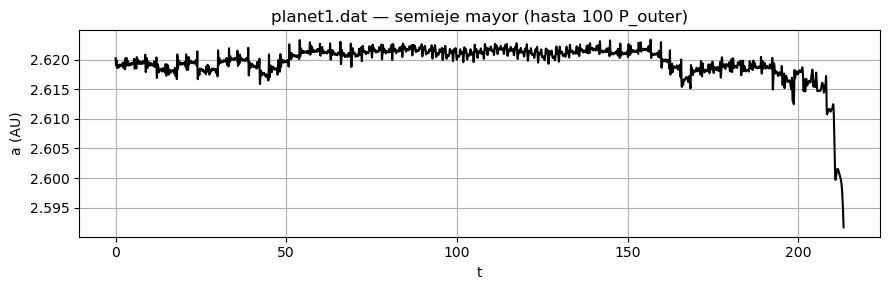

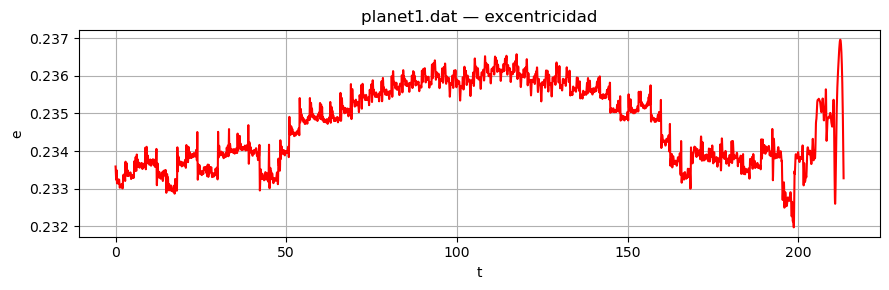

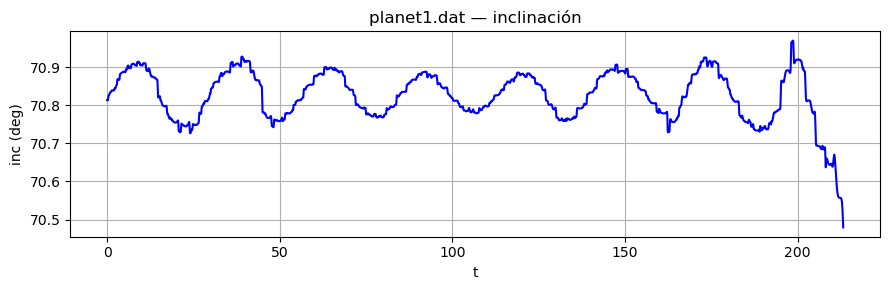

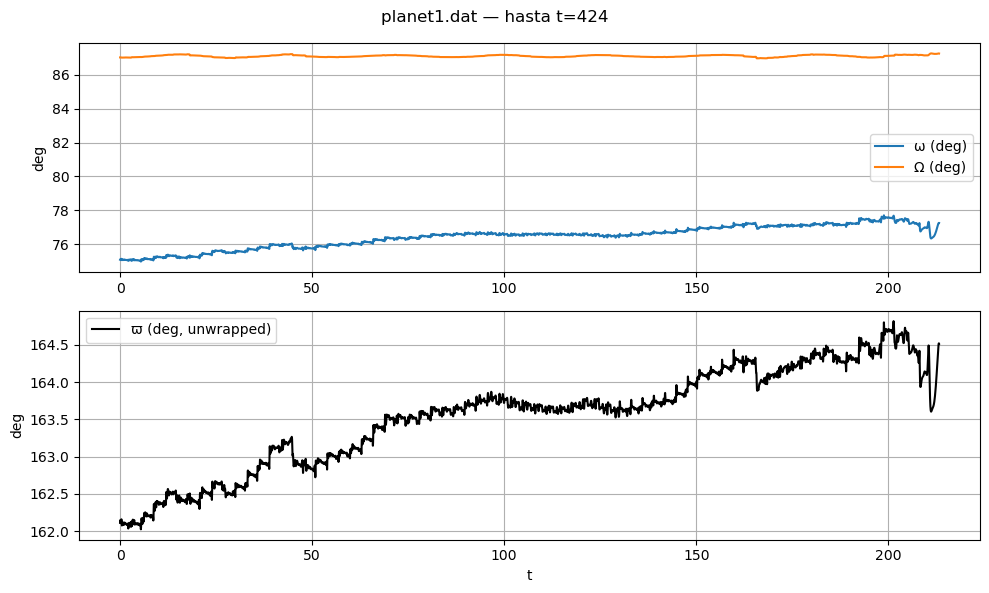

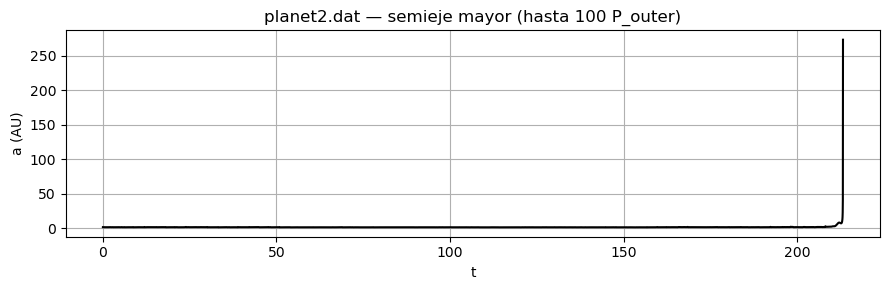

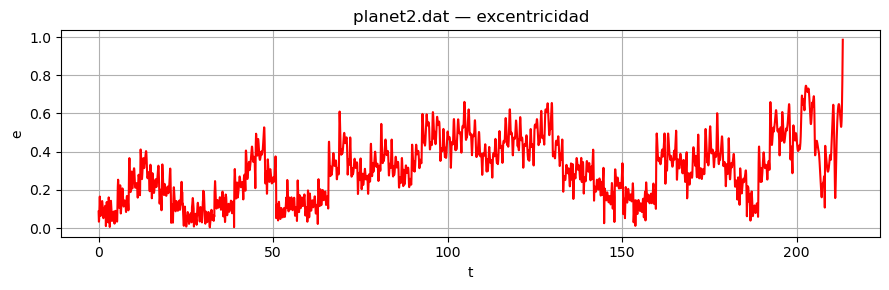

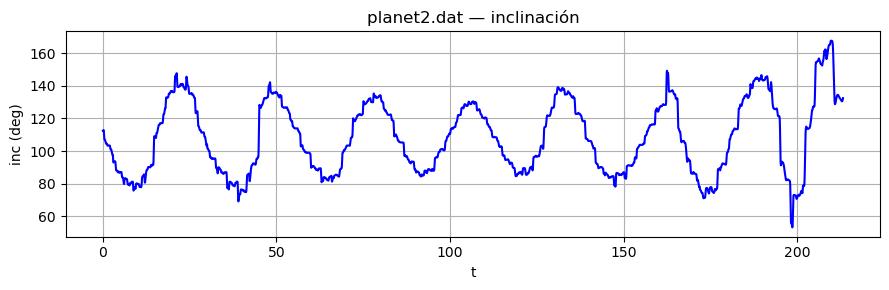

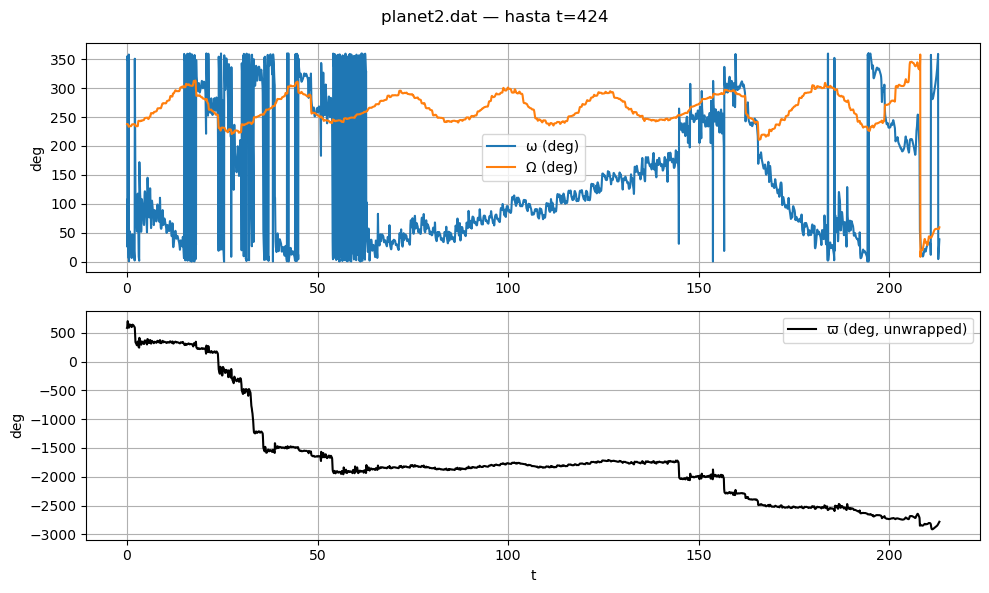

In [5]:
# ...existing code...
# Celda: graficar primeros 100 periodos del cuerpo más externo
import numpy as np
import matplotlib.pyplot as plt

# Ajusta si tu masa central no es 1 Msun
M_central = 1.0  # en masas solares

def orbital_period_years(a_AU, Mstar=M_central):
    # Kepler: P^2 = a^3 / Mstar  (P en years, a en AU, Mstar en Msun)
    return (a_AU**1.5) / np.sqrt(Mstar)

# determinar el cuerpo más externo usando semieje mayor máximo
if not planets:
    raise RuntimeError("No hay datos en 'planets'. Ejecuta la celda de carga primero.")

outer_name = None
outer_a = -np.inf
for name, p in planets.items():
    # p['a'] puede ser array; tomar valor medio o primer valor
    a0 = np.nanmean(p['a'])
    if a0 > outer_a:
        outer_a = a0
        outer_name = name

P_outer = orbital_period_years(outer_a)
print(f"Cuerpo más externo: {outer_name}, a ≈ {outer_a:.6g} AU -> P ≈ {P_outer:.6g} time_units")
t_start = None
# tomar t_start del primer planeta disponible
for p in planets.values():
    t_start = p['t'][0]
    break
t_end = t_start + 100.0 * P_outer
print(f"Graficando hasta t = {t_end:.6g} (100 * P_outer)")

# para cada planeta, recortar a t <= t_end y graficar
for fn, p in planets.items():
    t = p['t']
    mask = t <= t_end
    if not np.any(mask):
        print(f"{fn}: no hay datos hasta t_end ({t_end:.3g}), omitiendo")
        continue
    t_sel = t[mask]
    # downsample para visualización si hay demasiados puntos
    max_pts = 5000
    step = max(1, len(t_sel) // max_pts)
    t_plot = t_sel[::step]

    a_plot = p['a'][mask][::step]
    e_plot = p['e'][mask][::step]
    inc_plot = p['inc'][mask][::step]
    w_deg = p['w_deg'][mask][::step]
    O_deg = p['O_deg'][mask][::step]
    varpi_deg = np.rad2deg(compute_varpi(w_deg, O_deg))

    plt.figure(figsize=(9,3))
    plt.plot(t_plot, a_plot, '-k')
    plt.xlabel('t'); plt.ylabel('a (AU)'); plt.title(f"{fn} — semieje mayor (hasta 100 P_outer)"); plt.grid(True)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(t_plot, e_plot, '-r')
    plt.xlabel('t'); plt.ylabel('e'); plt.title(f"{fn} — excentricidad"); plt.grid(True)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(t_plot, inc_plot, '-b')
    plt.xlabel('t'); plt.ylabel('inc (deg)'); plt.title(f"{fn} — inclinación"); plt.grid(True)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t_plot, w_deg, label='ω (deg)')
    plt.plot(t_plot, O_deg, label='Ω (deg)')
    plt.legend(); plt.grid(True); plt.ylabel('deg')

    plt.subplot(2,1,2)
    plt.plot(t_plot, varpi_deg, '-k', label='ϖ (deg, unwrapped)')
    plt.legend(); plt.grid(True); plt.xlabel('t'); plt.ylabel('deg')

    plt.suptitle(f"{fn} — hasta t={t_end:.3g}")
    plt.tight_layout(); plt.show()

# ...existing code...